# Deep Kung-Fu with advantage actor-critic

In this notebook you'll build a deep reinforcement learning agent for Atari [Kung-Fu Master](https://gym.openai.com/envs/KungFuMaster-v0/) and train it with Advantage Actor-Critic.

Note that, strictly speaking, this will be neither [A3C](https://arxiv.org/abs/1602.01783) nor [A2C](https://openai.com/blog/baselines-acktr-a2c/), but rather a simplified version of the latter.

Special thanks to Jesse Grabowski for making an [initial version](https://www.coursera.org/learn/practical-rl/discussions/all/threads/6iDjkbhPQoGg45G4T7KBHQ/replies/5eM_hA7vEeuoKgpcLmLqdw) of the PyTorch port of this assignment.


## Package loading

In [2]:
# Imports
import gymnasium as gym
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from IPython.display import display, clear_output, HTML
import tqdm
from pathlib import Path
import time
import cv2

# Import our custom modules
from src.agent import Agent
from src.environment import make_env, EnvBatch, make_improved_env, ImprovedEnvBatch
from src.training import (
    compute_actor_critic_loss, 
    evaluate_agent, 
    train_agent, 
    train_agent_exploding_gradient,
    improved_compute_actor_critic_loss, 
    train_improved_agent
)
from src.utils import ewma, generate_video, display_video, compare_agent_results
from src.atari_util import PreprocessAtari
from src.reward_scaler import RewardScaler

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Visualizing the environment

Here we can see the game environment and how it's processed for the neural network agent. We see the original game frame, the cropped version, and the agent's perspective: four stacked grayscale images resized to 42x42 pixels, which serve as input to the neural network.

Created directory: outputs


/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment KungFuMasterDeterministic-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Observation shape: (4, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


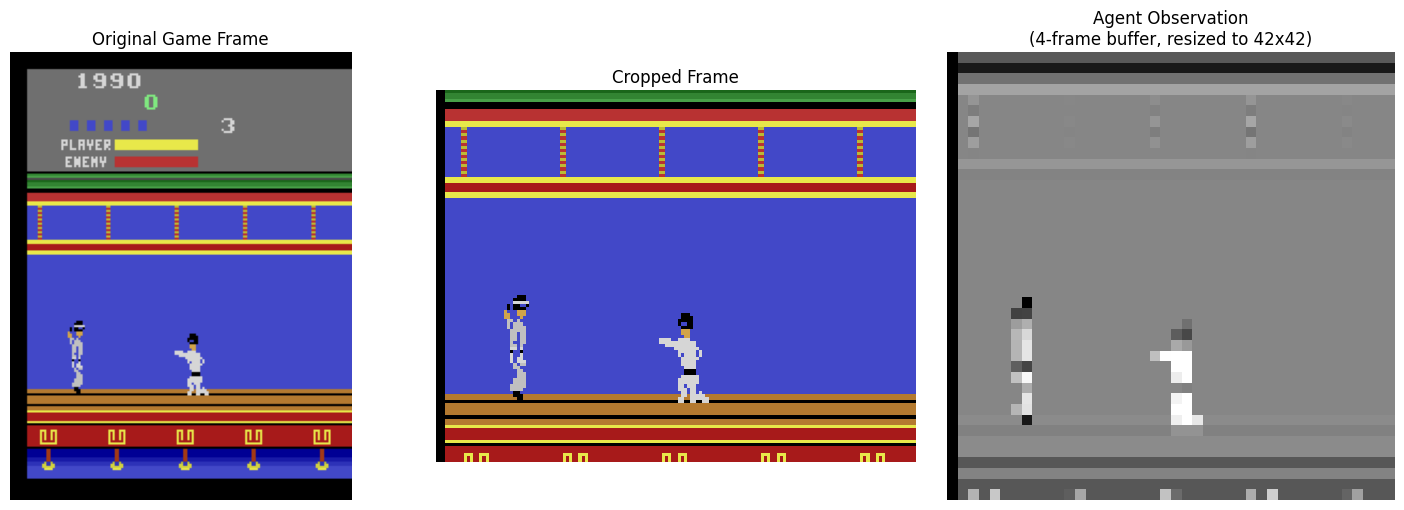

Plot has been displayed and saved as './outputs/environment_visualization.png'


In [2]:
# Check if the outputs folder exists
if not os.path.exists("./outputs"):
    # If it doesn't exist, create it
    os.mkdir("./outputs")
    print(f"Created directory: outputs")
else:
    print(f"Directory already exists: outputs")


# Environment Setup and Visualization
env = make_env()
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.unwrapped.get_action_meanings())

s = env.reset()
if isinstance(s, tuple):
    s = s[0]

for _ in range(100):
    step_result = env.step(env.action_space.sample())
    if len(step_result) == 5:  # New Gymnasium version
        s, _, _, _, _ = step_result
    else:  # Older version
        s, _, _, _ = step_result

# Render the environment
rendered_frame = env.render()

plt.figure(figsize=(15, 5))

# Original frame
plt.subplot(1, 3, 1)
plt.title('Original Game Frame')
plt.imshow(rendered_frame)
plt.axis('off')

# Cropped frame
plt.subplot(1, 3, 2)
plt.title('Cropped Frame')
cropped_frame = rendered_frame[60:-30, 5:]
plt.imshow(cropped_frame)
plt.axis('off')

# Agent's observation (4-frame buffer)
plt.subplot(1, 3, 3)
plt.title('Agent Observation\n(4-frame buffer, resized to 42x42)')
obs_reshaped = s.squeeze() if hasattr(s, 'squeeze') else s
obs_combined = np.max(obs_reshaped, axis=0)  # Combine 4 frames by taking max
plt.imshow(obs_combined, cmap='gray')
plt.axis('off')

plt.tight_layout()

# Display the plot in the notebook
display(plt.gcf())

# Save the figure
plt.savefig('./outputs/environment_visualization.png', dpi=300, bbox_inches='tight')

# Close the plot to free up memory
plt.close()

print("Plot has been displayed and saved as './outputs/environment_visualization.png'")

## Untrained Agent 

In [3]:
# Initialize agent
env = make_env()
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.unwrapped.get_action_meanings())

agent = Agent(input_dims=obs_shape, n_actions=n_actions, lr=1e-4)

# Test network
s = env.reset()
if isinstance(s, tuple):
    s = s[0]
state = torch.tensor([s], dtype=torch.float32, device=agent.device)
logits, state_values = agent(state)

print("\n" + "="*50)
print("NETWORK TEST")
print("="*50)
print("Action logits:")
print(logits)
print("\nState values:")
print(state_values)

# Create environment batch
env_batch = EnvBatch(10)

batch_states = env_batch.reset()
batch_actions = agent.choose_action(batch_states)
batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("\n" + "="*50)
print("ENVIRONMENT BATCH TEST")
print("="*50)
print(f"State shape: {batch_states.shape}")
print(f"Actions: {batch_actions}")
print(f"Rewards: {batch_rewards}")
print(f"Done: {batch_done}")

# Sanity check
l_act, l_crit, ent = compute_actor_critic_loss(agent, batch_states, batch_actions, batch_rewards, batch_next_states, batch_done)

print("\n" + "="*50)
print("SANITY CHECK")
print("="*50)
print(f"Entropy mean: {ent.mean():.4f}")
print(f"Log of number of actions: {np.log(n_actions):.4f}")

assert abs(l_act) < 100 and abs(l_crit) < 100, "Losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "Impossible entropy value, double-check the formula"

if ent.mean() < np.log(n_actions) / 2:
    print("WARNING: Entropy is too low for an untrained agent")
else:
    print("Entropy check passed")

print("Sanity check complete: Everything looks fine!")

# Generate and Display Videos for Untrained Agent
print("\n" + "="*50)
print("GENERATING VIDEOS OF UNTRAINED AGENT")
print("="*50)
env_monitor = make_env(video_folder="./videos_untrained")
rewards = evaluate_agent(agent, env_monitor, n_games=3)
print(f"Rewards of untrained agent: {rewards}")

# Display videos of untrained agent
video_names = sorted([str(s) for s in Path('videos_untrained').glob('*.mp4')])
video_html = """
<div style="display: flex; justify-content: space-around;">
""" + "".join(
    f"""
    <div style="margin-right: 10px;">
      <video width="480" height="360" controls>
        <source src="{video}" type="video/mp4">
      </video>
    </div>
    """ for video in video_names
) + "</div>"

print("\n" + "="*50)
print("DISPLAYING VIDEOS OF UNTRAINED AGENT")
print("="*50)
display(HTML(video_html))

/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment KungFuMasterDeterministic-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


Observation shape: (4, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


/tmp/ipykernel_15388/2786859458.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380164/work/torch/csrc/utils/tensor_new.cpp:275.)
  state = torch.tensor([s], dtype=torch.float32, device=agent.device)



NETWORK TEST
Action logits:
tensor([[-0.0481, -0.0364, -0.0703, -0.0494, -0.0603, -0.0064,  0.0128, -0.0275,
         -0.0363, -0.0430, -0.0690, -0.0091, -0.0329,  0.0426]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

State values:
tensor([0.0459], device='cuda:0', grad_fn=<SqueezeBackward1>)


/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment KungFuMasterDeterministic-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(



ENVIRONMENT BATCH TEST
State shape: (10, 4, 42, 42)
Actions: [12 11  0  6  5  5  9  6 10  9]
Rewards: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Done: [False False False False False False False False False False]

SANITY CHECK
Entropy mean: 2.6386
Log of number of actions: 2.6391
Entropy check passed
Sanity check complete: Everything looks fine!

GENERATING VIDEOS OF UNTRAINED AGENT
Reset called, preparing to record video for episode 1...


/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video ./videos_untrained/rl-video-episode-1.mp4.
Moviepy - Writing video ./videos_untrained/rl-video-episode-1.mp4



/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Moviepy - Done !
Moviepy - video ready ./videos_untrained/rl-video-episode-1.mp4
Reset called, preparing to record video for episode 2...
Moviepy - Building video ./videos_untrained/rl-video-episode-2.mp4.
Moviepy - Writing video ./videos_untrained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready ./videos_untrained/rl-video-episode-2.mp4
Reset called, preparing to record video for episode 3...
Moviepy - Building video ./videos_untrained/rl-video-episode-3.mp4.
Moviepy - Writing video ./videos_untrained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready ./videos_untrained/rl-video-episode-3.mp4
Rewards of untrained agent: [200.0, 600.0, 600.0]

DISPLAYING VIDEOS OF UNTRAINED AGENT


## Standard Agent with scalled rewards

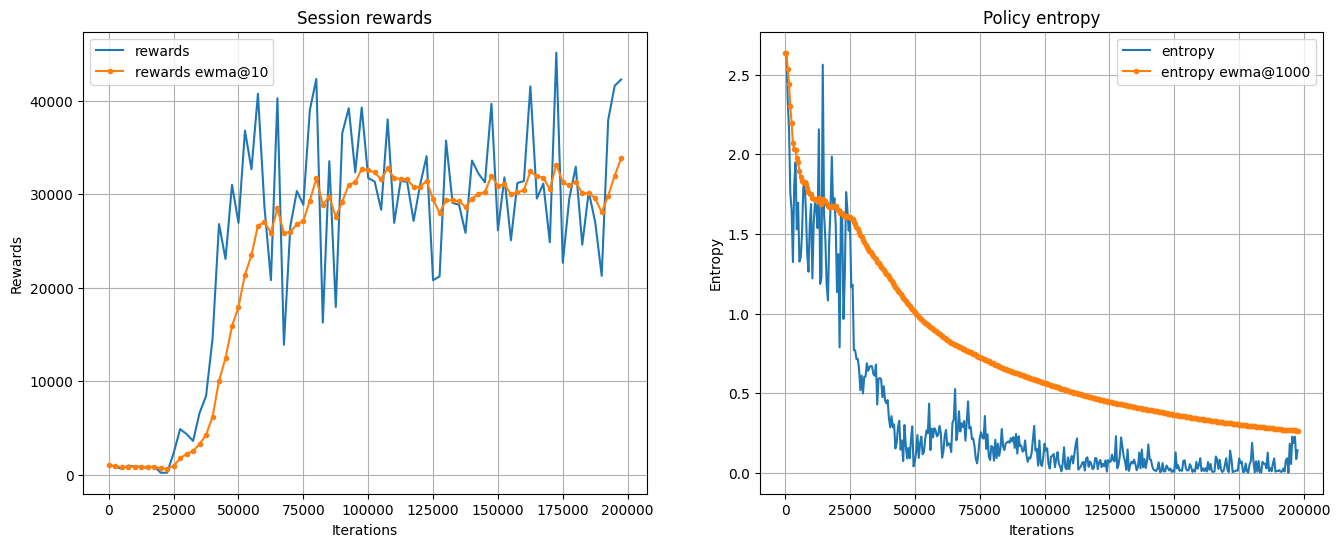

100%|██████████| 200000/200000 [2:00:15<00:00, 27.72it/s]  


Directory already exists: outputs
Model saved as trained_kungfu_agent.pth
Reset called, preparing to record video for episode 1...


/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video ./videos_trained/scaled_kungfu_video-episode-1.mp4.
Moviepy - Writing video ./videos_trained/scaled_kungfu_video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready ./videos_trained/scaled_kungfu_video-episode-1.mp4
Total episodes recorded: 1
Total reward: 22800.0
Video saved as scaled_kungfu_video.mp4


In [4]:
# Initial training
print("Starting initial training...")
agent, rewards_history, entropy_history, iterations_history = train_agent(n_iterations=200000)

# Save the trained model
if not os.path.exists("outputs"):
    os.makedirs("outputs")
    print(f"Created directory: outputs")
else:
    print(f"Directory already exists: outputs")

torch.save(agent.state_dict(), './outputs/trained_kungfu_agent.pth')
print("Model saved as trained_kungfu_agent.pth")

# Generate and display video for improved agent
video = generate_video(agent, make_env(video_folder="./videos_trained", video_name="scaled_kungfu_video.mp4"), "scaled_kungfu_video.mp4")
display_video("./videos_trained/scaled_kungfu_video-episode-1.mp4")

In [5]:
# Save scalled agent to a pickle file
data = {
    "rewards_history": rewards_history,
    "entropy_history": entropy_history,
    "iterations_history": iterations_history
}

# Define the filename for the combined pickle file
combined_filename = "./outputs/scaled_agent_results.pkl"

# Save the combined data to a single pickle file
with open(combined_filename, 'wb') as f:
    pickle.dump(data, f)

print(f"All data has been saved to {combined_filename}")

All data has been saved to ./outputs/scaled_agent_results.pkl


## Agent with no reward scalling

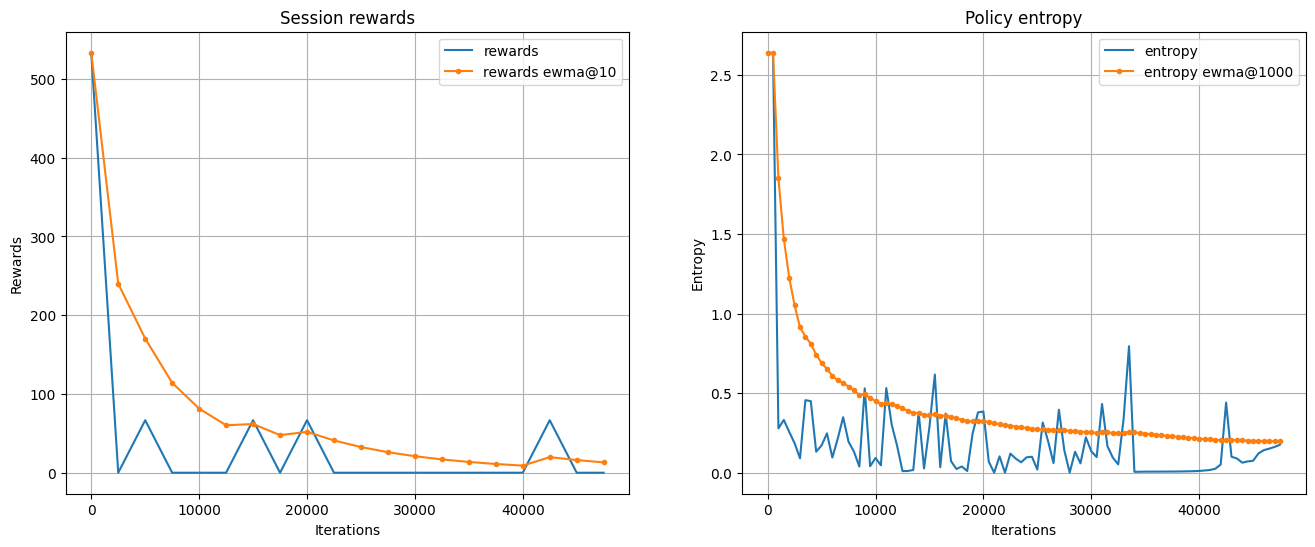

100%|██████████| 50000/50000 [21:52<00:00, 38.08it/s]


Model saved as exploded_trained_kungfu_agent.pth


/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/rrcaetano/data_science_portfolio/Deep_Learning/A3C/final_version/videos_trained folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Reset called, preparing to record video for episode 1...
Moviepy - Building video ./videos_trained/exploded_kungfu_video-episode-1.mp4.
Moviepy - Writing video ./videos_trained/exploded_kungfu_video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready ./videos_trained/exploded_kungfu_video-episode-1.mp4
Total episodes recorded: 1
Total reward: 0.0
Video saved as exploded_kungfu_video.mp4


In [6]:
# Exploding gradient test
print("Starting exploding gradient test...")
agent_exploding, rewards_history_exploding, entropy_history_exploding, iterations_exploding = train_agent_exploding_gradient(n_iterations=50000)

# Save the exploding gradient model
torch.save(agent_exploding.state_dict(), './outputs/exploded_trained_kungfu_agent.pth')
print("Model saved as exploded_trained_kungfu_agent.pth")

# Generate and display video for improved agent
generate_video(agent_exploding, make_env(video_folder="./videos_trained", video_name="exploded_kungfu_video.mp4"), "exploded_kungfu_video.mp4")
display_video("./videos_trained/exploded_kungfu_video-episode-1.mp4")


In [7]:
# Save exploded agent to a pickle file
data = {
    "rewards_history_exploding": rewards_history_exploding,
    "entropy_history_exploding": entropy_history_exploding,
    "iterations_exploding": iterations_exploding
}

# Define the filename for the combined pickle file
combined_filename = "./outputs/exploded_agent_results.pkl"

# Save the combined data to a single pickle file
with open(combined_filename, 'wb') as f:
    pickle.dump(data, f)

print(f"All data has been saved to {combined_filename}")

All data has been saved to ./outputs/exploded_agent_results.pkl


## Improved Agent

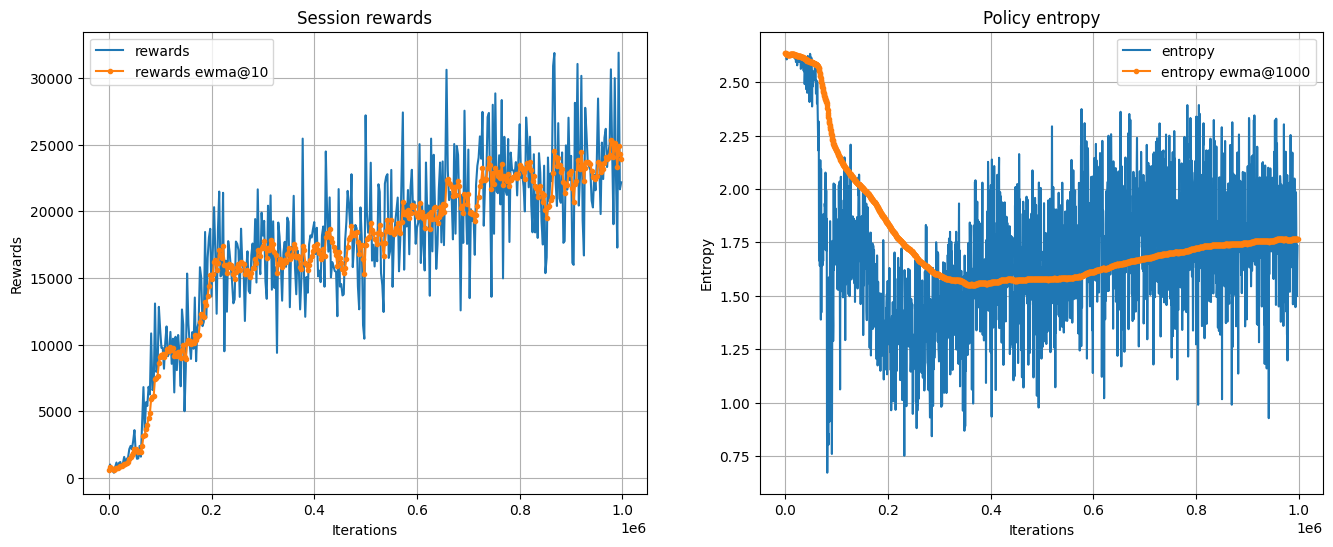

100%|██████████| 1000000/1000000 [9:31:12<00:00, 29.18it/s] 


Model saved as improved_trained_kungfu_agent.pth
Reset called, preparing to record video for episode 1...


/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/rrcaetano/data_science_portfolio/Deep_Learning/A3C/final_version/videos_trained folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/home/rrcaetano/anaconda3/envs/DQL/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video ./videos_trained/improved_kungfu_video-episode-1.mp4.
Moviepy - Writing video ./videos_trained/improved_kungfu_video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready ./videos_trained/improved_kungfu_video-episode-1.mp4
Total episodes recorded: 1
Total reward: 25200.0
Video saved as improved_kungfu_video.mp4


In [2]:
# Improved agent training
print("Starting improved agent training...")
improved_agent, improved_rewards, improved_entropy, improved_iterations = train_improved_agent(n_iterations=1000000)

# Save the improved trained model
torch.save(improved_agent.state_dict(), './outputs/improved_trained_kungfu_agent.pth')
print("Model saved as improved_trained_kungfu_agent.pth")

# Generate and display video for improved agent
generate_video(improved_agent, make_env(video_folder="./videos_trained", video_name="improved_kungfu_video.mp4"), "improved_kungfu_video.mp4")
display_video("./videos_trained/improved_kungfu_video-episode-1.mp4")

In [5]:
# Save improved agent to a pickle file
data = {
    "improved_rewards": improved_rewards,
    "improved_entropy": improved_entropy,
    "improved_iterations": improved_iterations
}

# Define the filename for the combined pickle file
combined_filename = "./outputs/improved_agent_results.pkl"

# Save the combined data to a single pickle file
with open(combined_filename, 'wb') as f:
    pickle.dump(data, f)

print(f"All data has been saved to {combined_filename}")

All data has been saved to ./outputs/improved_agent_results.pkl


## Compare Models

Plot saved to ./outputs/agent_comparison_plot.png


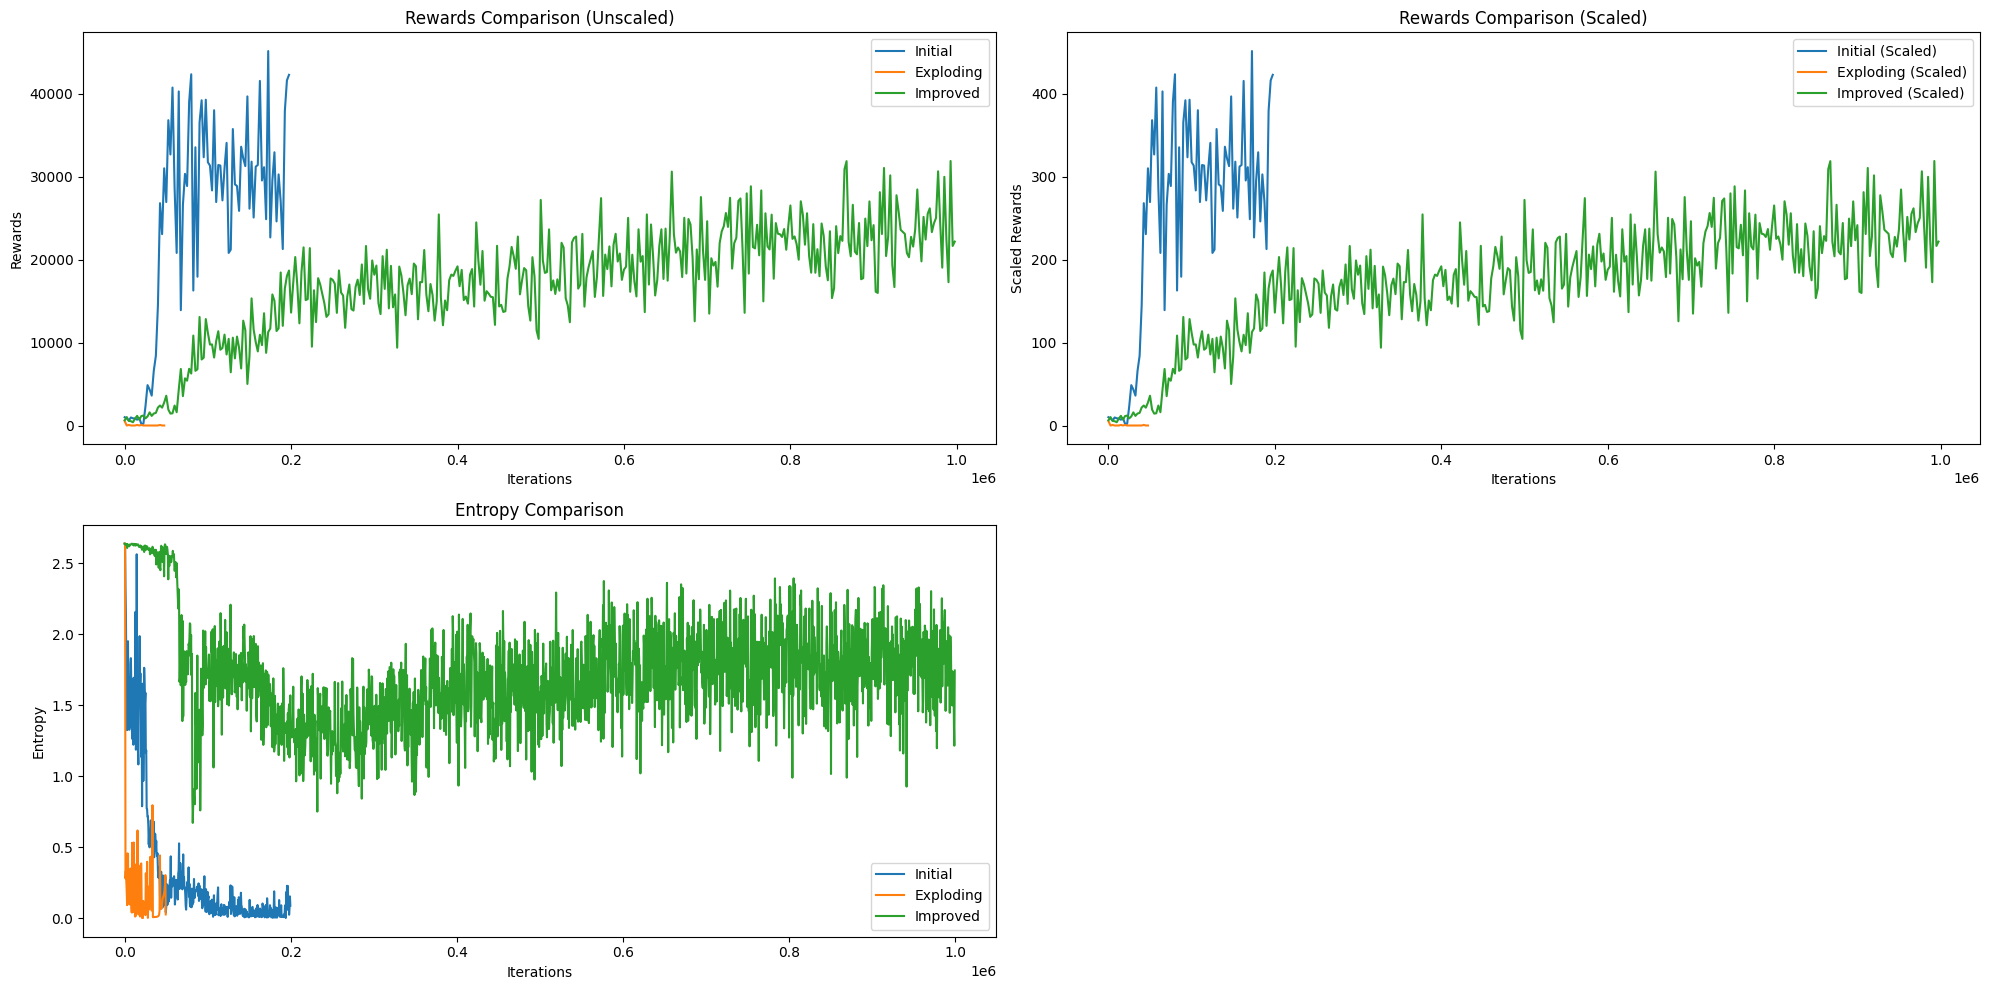

Performance Analysis:
Initial Agent - Final Reward: 42266.67, Final Entropy: 0.0886
Exploding Agent - Final Reward: 0.00, Final Entropy: 0.0270
Improved Agent - Final Reward: 22168.16, Final Entropy: 1.7445

Learning Speed Analysis:
Initial Agent - Learning Speed: 515.8333 reward/iteration
Exploding Agent - Learning Speed: -26.6667 reward/iteration
Improved Agent - Learning Speed: 53.8484 reward/iteration


In [3]:
# Load data from pickle files
def load_pickle_data(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

scaled_data = load_pickle_data("./outputs/scaled_agent_results.pkl")
exploded_data = load_pickle_data("./outputs/exploded_agent_results.pkl")
improved_data = load_pickle_data("./outputs/improved_agent_results.pkl")

# Combine all data into a single dictionary
all_data = {
    **scaled_data,
    **exploded_data,
    **improved_data
}

# Compare the 3 agents and save the plot
compare_agent_results(**all_data, save_path="./outputs/agent_comparison_plot.png")